# EARLI: Evolutionary Algorithm with RL Initialization
# Inference usage example

## Setup

### Install

Run the following steps **only if EARLI is not yet installed in your machine** (e.g., no need to install if you use EARLI's docker).

In [ ]:
# Verify Python>=3.10
import sys
print(sys.version)

#### GPU Check

Verify that an NVIDIA GPU is available and accessible.


In [1]:
import subprocess
import html
from IPython.display import display, HTML

def check_gpu():
    try:
        result = subprocess.run(["nvidia-smi"], capture_output=True, text=True, timeout=5)
        result.check_returncode()
        lines = result.stdout.splitlines()
        gpu_info = lines[2] if len(lines) > 2 else "GPU detected"
        gpu_info_escaped = html.escape(gpu_info)
        display(HTML(f"""
        <div style="border:2px solid #4CAF50;padding:10px;border-radius:10px;background:#e8f5e9;">
            <h3>✅ GPU is enabled</h3>
            <pre>{gpu_info_escaped}</pre>
        </div>
        """))
        return True
    except (subprocess.CalledProcessError, subprocess.TimeoutExpired, FileNotFoundError, IndexError) as e:
        display(HTML("""
        <div style="border:2px solid red;padding:15px;border-radius:10px;background:#ffeeee;">
            <h3>⚠️ GPU not detected!</h3>
            <p>This notebook requires a <b>GPU runtime</b>.</p>
            
            <h4>If running in Google Colab:</h4>
            <ol>
              <li>Click on <b>Runtime → Change runtime type</b></li>
              <li>Set <b>Hardware accelerator</b> to <b>GPU</b></li>
              <li>Then click <b>Save</b> and <b>Runtime → Restart runtime</b>.</li>
            </ol>
            
            <h4>If running in Docker:</h4>
            <ol>
              <li>Ensure you have <b>NVIDIA Docker runtime</b> installed (<code>nvidia-docker2</code>)</li>
              <li>Run container with GPU support: <code>docker run --gpus all ...</code></li>
              <li>Or use: <code>docker run --runtime=nvidia ...</code> for older Docker versions</li>
              <li>Verify GPU access: <code>docker run --gpus all nvidia/cuda:12.0.0-base-ubuntu22.04 nvidia-smi</code></li>
            </ol>
            
            <p><b>Additional resources:</b></p>
            <ul>
              <li><a href="https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/install-guide.html" target="_blank">NVIDIA Container Toolkit Installation Guide</a></li>
            </ul>
        </div>
        """))
        return False

check_gpu()


True

In [ ]:
# Install build tools for compiling C/C++ extensions.
# If you have root on this notebook (e.g. in Google Colab): uncomment.
# Otherwise: install this outside the notebook.
!apt-get update -y && apt-get install -y git build-essential ninja-build

In [ ]:

!pip uninstall -y cuda-python cuda-bindings cuda-core

# For cuda 12
!pip install --upgrade --extra-index-url https://pypi.nvidia.com cuopt-cu12 nvidia-nvjitlink-cu12 rapids-logger==0.1.19

# For cuda 13
# !pip install --upgrade --extra-index-url https://pypi.nvidia.com cuopt-cu13 nvidia-nvjitlink-cu13 rapids-logger==0.1.19 # For cuda 13

### If Running in colab, please paste the setup code generated in launcher notebook in the below cell


In [ ]:
# If Running in colab, please paste the setup code generated in launcher notebook in the below cell


In [ ]:
!pip install --upgrade --extra-index-url https://pypi.nvidia.com -c constraints.txt git+https://github.com/NVlabs/EARLI.git

### Import

In [1]:
import pickle as pkl
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from importlib.resources import files, as_file
from pathlib import Path
import yaml
import os
os.environ["WANDB_NOTEBOOK_NAME"] = "initializing_cuopt_with_rl_solutions.ipynb"

import earli
from earli.utils import analysis_utils as utils
from earli import download_data, main, test_injection

### Download data

Download test dataset of VRP instances in Sao Paulo and Rio, based on the [Olist benchmark](https://github.com/NVlabs/olist-vrp-benchmark).

In [2]:
download_data.main(['--cleanup', '--force'])

test_problems.zip: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 941M/941M [00:21<00:00, 45.2MB/s]


Successfully downloaded to datasets/test_problems.zip
Extracting datasets/test_problems.zip to datasets
Successfully extracted to datasets

Extracted contents in datasets/test_problems:
  vrp-test-size-100-rio-n_problems-256.pkl (10.4 MB)
  vrp-test-size-100-sp-n_problems-256.pkl (10.4 MB)
  vrp-test-size-200-rio-n_problems-256.pkl (40.2 MB)
  vrp-test-size-200-sp-n_problems-256.pkl (40.2 MB)
  vrp-test-size-300-rio-n_problems-256.pkl (89.7 MB)
  vrp-test-size-300-sp-n_problems-256.pkl (89.7 MB)
  vrp-test-size-400-rio-n_problems-256.pkl (158.6 MB)
  vrp-test-size-400-sp-n_problems-256.pkl (158.6 MB)
  vrp-test-size-50-rio-n_problems-256.pkl (2.7 MB)
  vrp-test-size-50-sp-n_problems-256.pkl (2.7 MB)
  vrp-test-size-500-rio-n_problems-256.pkl (247.1 MB)
  vrp-test-size-500-sp-n_problems-256.pkl (247.1 MB)
  vrp-validation-size-100-rio-n_problems-64.pkl (2.6 MB)
  vrp-validation-size-100-sp-n_problems-64.pkl (2.6 MB)
  vrp-validation-size-200-rio-n_problems-64.pkl (10.1 MB)
  vrp-validat

In [2]:
ls -lh datasets/problem_instances/vrp-test-size-100-sp-n_problems-256.pkl

-rw-r--r-- 1 361940531 root 11M Sep 21 17:10 datasets/test_problems/vrp-test-size-100-sp-n_problems-256.pkl


### Find pre-trained models path

In [2]:
def get_models_dir() -> str:
    # Preferred: importlib.resources (works for wheels/zip installs)
    try:
        res = files("earli") / "pretrained_models"
        with as_file(res) as p:
            if p.exists():
                return str(p)
    except Exception:
        pass
    # Fallback: derive from package file location (works for editable installs)
    p = Path(earli.__file__).resolve().parent / "pretrained_models"
    if p.exists():
        return str(p)
    raise FileNotFoundError("Could not locate packaged 'earli/pretrained_models' directory.")

def patch_config_yaml(cfg_path: str, models_dir: str):
    """Read the model filename from the config, rewrite with the correct dir."""
    cfg = Path(cfg_path)
    data = yaml.safe_load(cfg.read_text())

    if "train" not in data or "pretrained_fname" not in data["train"]:
        raise KeyError("Config missing train.pretrained_fname")

    old_path = Path(data["train"]["pretrained_fname"])
    model_name = old_path.name
    new_path = Path(models_dir) / model_name

    data["train"]["pretrained_fname"] = str(new_path)
    cfg.write_text(yaml.safe_dump(data, sort_keys=False))
    print(f"Updated {cfg} → pretrained_fname = {new_path}")

In [4]:
models_dir = get_models_dir()
patch_config_yaml("configs/config.yaml", models_dir)

## Run RL initialization

Run the RL agent with the arguments specified in `config.yaml`.

Key arguments:
* `data_file`: Pickle file that containst the problem instances (e.g., one of the files downloaded above).
* `problem_range`: Which problem instances to solve (range of indices, e.g., \[0,16\] for the first 16 instances).
* `pretrained_fname`: Path of pretrained model to be used. We provide several compatible models under `pretrained_models/`.
* `n_beams`: Number of solutions to generate per instance.
* `n_parallel_problems`: Number of solutions to be generated in parallel. Larger is faster but consumes more GPU memory. **Reduce this in case of out-of-memory error**.

In [3]:
main.main('configs/config.yaml')

Applying RL solver to 256 problem instances...
test time part 1/1: 0:00:05

Local-search duration per problem (for 8 solutions): 0.004433998838067055 +- 1.8942679265827057e-05 [s]
-------------------------------------
| test/                  |          |
|    mean_game_clocktime | 0.0234   |
|    mean_game_iters     | 108      |
|    mean_reward         | -2.29    |
|    std_reward          | 0.279    |
|    total_games         | 256      |
-------------------------------------
Saving logs to: ./outputs/test_logs.pkl


## Run solver

Run the cuOpt solver with the arguments specified in `config_initialization.yaml`.

Key arguments:
* `methods`: Initialization methods to run (default / EARLI).
* `problems`: Same as `data_file` above.
* `solutions`: The RL solutions file (printed in the RL output under `Saving logs to`). Set to `null` if no solutions are available.
* `problem_range`: Which problem instances to solve (range of indices, e.g., \[0,16\] for the first 16 instances).
* `runtimes`: Solver runtimes to be tested. Should not be lower than `rl_runtime`.
* `rl_runtime`: RL runtime to be reduced from the solver time. Should be set to the mean runtime of the RL agent (printed in the RL output as `mean_game_clocktime`). The default falls back to the timings on our experiments, e.g., 0.767s for 500 customers.

In [4]:
%%time
test_injection.main('configs/config_initialization.yaml')


injection
CuOpt version: 25.05.01
Problems: datasets/test_problems/vrp-test-size-100-sp-n_problems-256.pkl
Solutions: ['outputs/test_logs.pkl']
Problems: 0-255

SOLVER_RUNTIME = 0.016:


21-09 [MainThread  ] init
21-09 [MainThread  ] init


Finished problem 1.001.1/5.256.2.
Finished problem 1.001.2/5.256.2.
Finished problem 1.002.1/5.256.2.
Finished problem 1.002.2/5.256.2.
Finished problem 1.003.1/5.256.2.
Finished problem 1.003.2/5.256.2.
Finished problem 1.004.1/5.256.2.
Finished problem 1.004.2/5.256.2.
Finished problem 1.005.1/5.256.2.
Finished problem 1.005.2/5.256.2.
Finished problem 1.006.1/5.256.2.
Finished problem 1.006.2/5.256.2.
Finished problem 1.007.1/5.256.2.
Finished problem 1.007.2/5.256.2.
Finished problem 1.008.1/5.256.2.
Finished problem 1.008.2/5.256.2.
Finished problem 1.009.1/5.256.2.
Finished problem 1.009.2/5.256.2.
Finished problem 1.010.1/5.256.2.
Finished problem 1.010.2/5.256.2.
Finished problem 1.011.1/5.256.2.
Finished problem 1.011.2/5.256.2.
Finished problem 1.012.1/5.256.2.
Finished problem 1.012.2/5.256.2.
Finished problem 1.013.1/5.256.2.
Finished problem 1.013.2/5.256.2.
Finished problem 1.014.1/5.256.2.
Finished problem 1.014.2/5.256.2.
Finished problem 1.015.1/5.256.2.
Finished probl

The output above presents the solution costs with and without RL initialization, and the difference between them, for every time-budget.

## Plot results

Read solver stats:

In [5]:
fpath = r'outputs/test_summary_injection.pkl'
with open(fpath, 'rb') as hh:
    dd = pkl.load(hh)
rr, info = dd['summary'], dd['info']

methods_map = dict(cuOpt='cuOpt', cuOpt_RL='EARLI')
rr, _ = utils.injection_post_process(rr, None, methods_map, baseline='cuOpt')

rr

/work/utils/analysis_utils.py:872: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.60375898 -0.06970313 -1.19780382 ...  0.16904881 -0.8352865
 -0.93636435]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rr.loc[rr.method == method, f'{ycol}_vs_{baseline}_ratio [%]'] = 100 * (


,method,total_runtime,init_runtime,problem_id,vehicles,cost,attempted_injections,accepted,rejected,unconsidered,...,method0,best_vehicles,vehicles_suboptimality_diff [%],vehicles_suboptimality_ratio [%],vehicles_vs_cuOpt_ratio [%],best_cost,cost_suboptimality_diff [%],cost_suboptimality_ratio [%],cost_vs_cuOpt_ratio [%],n_accepted
0,cuOpt,0.016,0.000,0,11.0,96910.000294,0,0,0,0,...,cuOpt,11.0,0.0,0.0,0.0,94377.499199,2.785947,2.683374,0.000000,0
1,EARLI,0.016,0.016,0,11.0,98464.203125,0,0,0,0,...,cuOpt_RL,11.0,0.0,0.0,0.0,94377.499199,4.495689,4.330168,1.603759,0
2,cuOpt,0.016,0.000,1,9.0,87504.899904,0,0,0,0,...,cuOpt,9.0,0.0,0.0,0.0,83341.100088,4.580501,4.996094,0.000000,0
3,EARLI,0.016,0.016,1,9.0,87443.906250,0,0,0,0,...,cuOpt_RL,9.0,0.0,0.0,0.0,83341.100088,4.513403,4.922909,-0.069703,0
4,cuOpt,0.016,0.000,2,11.0,86676.400736,0,0,0,0,...,cuOpt,11.0,0.0,0.0,0.0,84049.100579,2.890233,3.125911,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,EARLI,1.000,0.016,253,12.0,89711.200748,8,2,6,0,...,cuOpt_RL,12.0,0.0,0.0,0.0,89559.800970,0.166551,0.169049,0.169049,2
2556,cuOpt,1.000,0.000,254,8.0,84976.900198,0,0,0,0,...,cuOpt,8.0,0.0,0.0,0.0,84267.099620,0.780835,0.842322,0.000000,0
2557,EARLI,1.000,0.016,254,8.0,84267.099620,8,7,1,0,...,cuOpt_RL,8.0,0.0,0.0,0.0,84267.099620,0.000000,0.000000,-0.835287,5+
2558,cuOpt,1.000,0.000,255,8.0,99523.300718,0,0,0,0,...,cuOpt,8.0,0.0,0.0,0.0,98591.400010,1.025163,0.945215,0.000000,0


Plot the ratio of instances where the solver found a feasible solution:

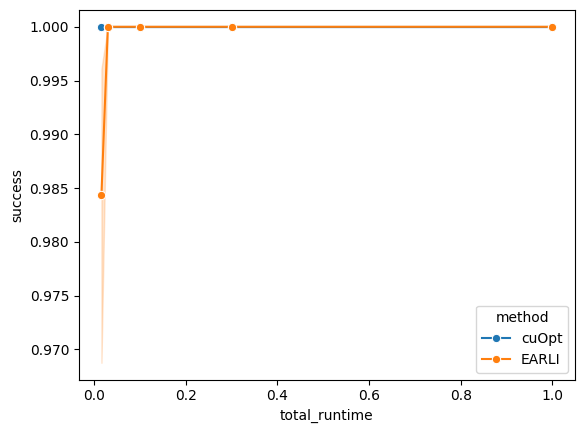

In [6]:
sns.lineplot(data=rr, x='total_runtime', hue='method', y='success', marker='o');

Plot cost gaps: how far was the solver cost from the best known cost, on average over instances?

Removing 0 problems with suboptimal vehicles (0.0%)


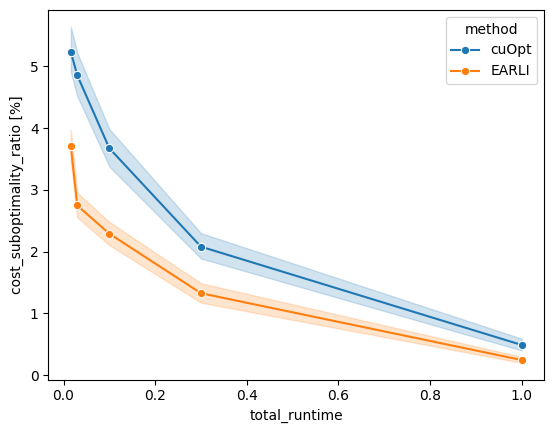

In [8]:
# remove instances in which some of the solvers did not find a feasible solution (since these instances may unfairly bias the cost evaluation).
rr = utils.add_col_all_success(rr)
n_removed = (~rr.all_success).sum()
print(f'Removing {n_removed:d} problems with suboptimal vehicles ({100*n_removed/len(rr):.1f}%)')
rr = rr[rr.all_success]

sns.lineplot(data=rr, x='total_runtime', hue='method', y='cost_suboptimality_ratio [%]', marker='o');

## Visualize solutions

In [18]:
method0 = 'cuOpt'
method1 = 'cuOpt_RL'
methods_map = dict(cuOpt='cuOpt', cuOpt_RL='EARLI')
problem_id = 0
runtime = 0.3  # [s]
area = 'sao_paulo'  # None / 'rio' / 'sao_paulo'

In [19]:
def extract_solution(info, runtime, problem_id, method):
    method_lab = method.replace('+', '_')
    key = f'time_{int(np.round(runtime))}_problem_{problem_id}_{method_lab}_iter_0'
    if key not in info['solutions']:
        print(key)
        raise Exception(f'Solution {key} was not found.')
    return info['solutions'][key]

# extract solutions
sol0 = extract_solution(info, runtime, problem_id, method0)
sol1 = extract_solution(info, runtime, problem_id, method1)

# extract problem instances
with open(info['config']['paths']['problems'], 'rb') as hh:
    problems = pkl.load(hh)

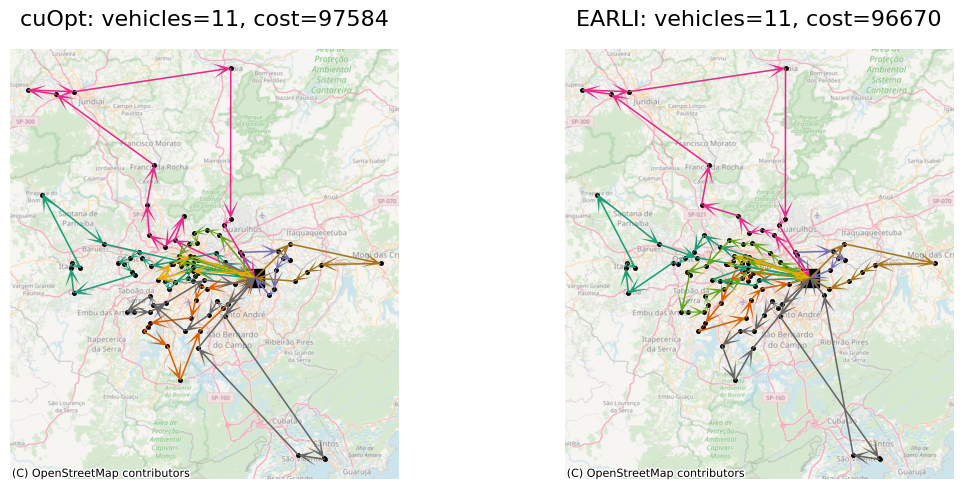

In [20]:
utils.display_solutions(rr, sol0, sol1, problems, problem_id, method0, method1, runtime, methods_map, area);

## License

SPDX-FileCopyrightText: Copyright (c) 2025 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
SPDX-License-Identifier: Apache-2.0

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
